In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import accuracy_score
from scipy.special import expit
import time


df = pd.read_csv('responses.csv', sep=",")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [127]:
# change NaN number values to the mean
df_imputed = df.fillna(df.median())
# get categorical features
object_features = list(df.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

In [128]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'Fear of public speaking' in df_fixed:
    y = df_fixed['Fear of public speaking'].values # get the labels we want
    del df_fixed['Fear of public speaking'] # get rid of the class label
    X = expit(df_fixed.values) # use everything else to predict!

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [129]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

# blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

# blr.fit(X,y)
# print(blr)

# yhat = blr.predict(X)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 36 µs


In [130]:
%%time
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X + 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
       
# hlr = HessianBinaryLogisticRegression(eta=0.1,iterations=20,C=0.1) # note that we need only a few iterations here

# hlr.fit(X,y)
# yhat = hlr.predict(X)
# print(hlr)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 40.1 µs


In [131]:
%%time
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
from scipy.optimize import OptimizeResult

import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    @staticmethod
    def line_search_function(eta,X,y,w,grad):
        wnew = w + grad*eta
        yhat = (1/(1+np.exp(-X @ wnew)))>0.5
        return np.sum((y-yhat)**2)+np.sum(wnew**2)
    @staticmethod
    def line_search_function_l1(eta,X,y,w,grad):
        if(math.sin(w) < 0 ):
            w -=1
        elif(math.sin(w) > 0):
            w += 1
        else:
            w = w
        wnew = w + grad*eta
        yhat = (1/(1+np.exp(-X @ wnew)))>0.5
        return np.sum((y-yhat)**2)+np.sum(math.fabs(wnew))
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/20} # unclear exactly what this should be
            res = minimize_scalar(self.line_search_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ += gradient*eta # set new function values
                
            

# lslr = LineSearchLogisticRegression(eta=0.1,iterations=110, C=0.001)

# lslr.fit(X,y)

# yhat = lslr.predict(X)
# print(lslr)
# print('Accuracy of: ',accuracy_score(y,yhat))         

CPU times: user 61 µs, sys: 4 µs, total: 65 µs
Wall time: 76.1 µs


In [132]:
%%time
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    
    
# slr = StochasticLogisticRegression(0.1,1000, C=0.001) # take a lot more steps!!

# slr.fit(X,y)

# yhat = slr.predict(X)
# print(slr)
# print('Accuracy of: ',accuracy_score(y,yhat))      

CPU times: user 43 µs, sys: 1 µs, total: 44 µs
Wall time: 47.9 µs


In [133]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += 2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        self.w_ = self.w_.reshape((num_features,1))
            
# bfgslr = BFGSBinaryLogisticRegression(_,2) # note that we need only a few iterations here

# bfgslr.fit(X,y)
# yhat = bfgslr.predict(X)
# print(bfgslr)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 38 µs, sys: 1 µs, total: 39 µs
Wall time: 41 µs


In [134]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimization=None):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        self.optimization = optimization
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            #hblr = HessianBinaryLogisticRegression(self.eta,self.iters,self.C)
            if(self.optimization == "BFGSBinaryLogisticRegression"):
                hblr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.C)
            elif(self.optimization == "StochasticLogisticRegression"):
                hblr = StochasticLogisticRegression(self.eta,self.iters,self.C)
            else:
                hblr = LineSearchLogisticRegression(self.eta,self.iters,self.C)

            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



In [135]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants


lr_clf = MultiClassLogisticRegression(eta=0.1,iterations=2500, C=0.006, optimization="BFGSBinaryLogisticRegression") # get object
lr_clf_accuracies = []
lr_clf_times = []
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = expit(X[train_indices])
    y_train = y[train_indices]
    
#     print(X_train)
#     print(y_train)
    
    X_test = expit(X[test_indices])
    y_test = y[test_indices]
    
    st = time.time()
    lr_clf.fit(X_train,y_train)  # train object
    t = (time.time() -st)
    lr_clf_times.append(t)
    
    # train the reusable logisitc regression model on the training data
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat+1)
    lr_clf_accuracies.append(acc)
    conf = mt.confusion_matrix(y_test,y_hat+1)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.336633663366
confusion matrix
 [[ 0  0 39  0  0]
 [ 0  0 44  0  0]
 [ 0  0 68  0  0]
 [ 0  0 34  0  0]
 [ 0  0 17  0  0]]
====Iteration 1  ====
accuracy 0.311881188119
confusion matrix
 [[ 0  0 37  0  0]
 [ 0  0 42  0  0]
 [ 0  0 63  0  0]
 [ 0  0 44  0  0]
 [ 0  0 16  0  0]]
====Iteration 2  ====
accuracy 0.336633663366
confusion matrix
 [[ 0  0 30  0  0]
 [ 0  0 44  0  0]
 [ 0  0 68  0  0]
 [ 0  0 43  0  0]
 [ 0  0 17  0  0]]


In [136]:
%%time
lr = MultiClassLogisticRegression(eta=0.1,iterations=10,C=0.0001)
lr.fit(X,y)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat+1))

MultiClass Logistic Regression Object with coefficients:
[[-0.05879671 -0.05804428 -0.05526859 -0.06054565 -0.052267   -0.05351393
  -0.05683023 -0.06197697 -0.06155897 -0.05704704 -0.05106109 -0.05795078
  -0.0529062  -0.0477312  -0.05412005 -0.05605494 -0.04988172 -0.05426526
  -0.05548312 -0.05012395 -0.05915867 -0.0500789  -0.06567154 -0.05777443
  -0.06066835 -0.06173793 -0.0503009  -0.06066656 -0.06476976 -0.06023164
  -0.0471049  -0.05563847 -0.04584592 -0.04778198 -0.03651198 -0.05318108
  -0.03835143 -0.0574508  -0.05096968 -0.03521597 -0.06329312 -0.0588248
  -0.05537848 -0.05057318 -0.05775464 -0.06147044 -0.02760299 -0.03847083
  -0.04607932 -0.04512763 -0.06506676 -0.04865159 -0.04216681 -0.04707778
  -0.05371216 -0.04146041 -0.05815593 -0.07010551 -0.05526274 -0.05211043
  -0.0522725  -0.05581161 -0.03786508 -0.06547102 -0.07566846 -0.06516685
  -0.07262119 -0.07434775 -0.07708026 -0.07876693 -0.07366707 -0.07082593
  -0.0825835  -0.05968502 -0.04427827 -0.04620992 -0.054

In [137]:
# linear boundaries visualization from sklearn documentation
from matplotlib import pyplot as plt
import copy
%matplotlib inline

def plot_decision_boundaries(lr,Xin,y,title=''):
    Xb = copy.deepcopy(Xin)
    lr.fit(Xb[:,:2],y) # train only on two features

    h=0.01
    # create a mesh to plot in
    x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
    y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb[:, 0], Xb[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Feature')
    plt.ylabel('Fear of Public Speaking')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()


In [138]:


costs = [n for n in np.arange(0,0.01,0.002)]
optimizations = ["BFGSBinaryLogisticRegression","StochasticLogisticRegression","LineSearchLogisticRegression"]

for optimization in optimizations:
    for cost in costs:
        %%time
        lr = MultiClassLogisticRegression(eta=0.1,
                                           iterations=10,
                                           C=cost,optimization=optimization) # get object
        lr.fit(X,y)
#         print(lr)
        yhat = lr.predict(X)
        print('For ',optimization,' and cost ', cost,' Accuracy of: ',accuracy_score(y,yhat+1))
        


CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 6.91 µs
For  BFGSBinaryLogisticRegression  and cost  0.0  Accuracy of:  0.453465346535
CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 7.15 µs
For  BFGSBinaryLogisticRegression  and cost  0.002  Accuracy of:  0.444554455446
CPU times: user 9 µs, sys: 6 µs, total: 15 µs
Wall time: 8.11 µs
For  BFGSBinaryLogisticRegression  and cost  0.004  Accuracy of:  0.414851485149
CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs
For  BFGSBinaryLogisticRegression  and cost  0.006  Accuracy of:  0.372277227723
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
For  BFGSBinaryLogisticRegression  and cost  0.008  Accuracy of:  0.372277227723
CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 6.91 µs
For  StochasticLogisticRegression  and cost  0.0  Accuracy of:  0.305940594059
CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 7.15 µs
For  StochasticLogisticRegression  and cost  0.002  Accuracy of

In [139]:
%%time
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression(solver='lbfgs')#,max_iter=100,C=0.005) 
lr_sk.fit(X,y)
#print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))


Accuracy of:  0.548514851485
CPU times: user 614 ms, sys: 23.9 ms, total: 638 ms
Wall time: 164 ms


In [140]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants


lr_sk = SKLogisticRegression(solver='lbfgs')#,max_iter=100,C=0.005) 

lr_sk_accuracies = []
lr_sk_times = []
# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
#     print(X_train)
#     print(y_train)
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    st = time.time()
    lr_sk.fit(X_train,y_train)
    t = (time.time() -st)
    lr_sk_times.append(t)
    #print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
    yhat = lr_sk.predict(X_test)
 
    print("Iterations ",lr_sk.n_iter_)
    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    lr_sk_accuracies.append(acc)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

print(lr_sk_times)
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

Iterations  [100 100  91 100  37]
====Iteration 0  ====
accuracy 0.237623762376
confusion matrix
 [[ 0 30  0  0  0]
 [ 0 48  0  0  0]
 [ 0 68  0  0  0]
 [ 0 40  0  0  0]
 [ 0 16  0  0  0]]
Iterations  [100 100 100 100 100]
====Iteration 1  ====
accuracy 0.222772277228
confusion matrix
 [[ 0 30  0  0  0]
 [ 0 45  0  0  0]
 [ 0 65  0  0  0]
 [ 0 41  0  0  0]
 [ 0 21  0  0  0]]
Iterations  [100 100 100 100  61]
====Iteration 2  ====
accuracy 0.237623762376
confusion matrix
 [[ 0 43  0  0  0]
 [ 0 48  0  0  0]
 [ 0 54  0  0  0]
 [ 0 39  0  0  0]
 [ 0 18  0  0  0]]
[0.1221010684967041, 0.14481019973754883, 0.12372183799743652]


18.856000900268555


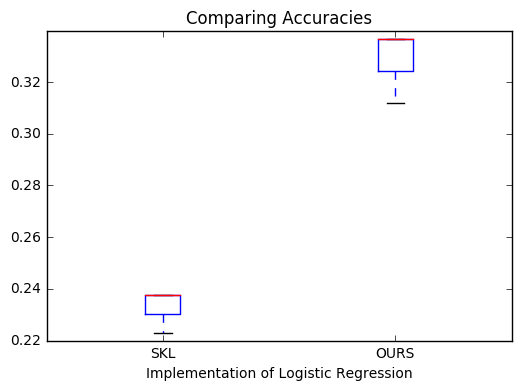

In [141]:
plt.boxplot([lr_sk_accuracies,lr_clf_accuracies])
plt.title("Comparing Accuracies")
plt.xlabel('Implementation of Logistic Regression')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()
print((time.time() -st)*100)
# ax = fig.add_subplot(111)


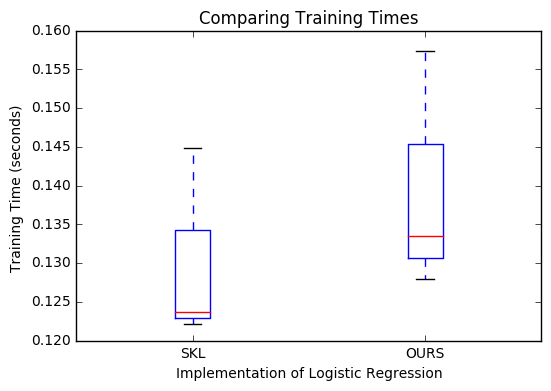

In [142]:
plt.boxplot([lr_sk_times,lr_clf_times])
plt.title("Comparing Training Times")
plt.xlabel('Implementation of Logistic Regression')
plt.ylabel('Training Time (seconds) ')
plt.xticks([1,2],['SKL','OURS'])
plt.figure()

In [143]:
print(lr_sk_times)
print(lr_clf_times)


[0.1221010684967041, 0.14481019973754883, 0.12372183799743652]
[0.15733003616333008, 0.13342595100402832, 0.12798094749450684]


In [144]:
t1 = [time/100 for time in lr_clf_times ]